<a href="https://colab.research.google.com/github/hiydavid/numerai-models/blob/main/numerai_features_eda_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerai Feature EDA

* Tournament data and example predictions change every week
* Training and validation data only change periodically

---
## Load libraries & datasets

In [2]:
# libs
import matplotlib
import numpy as np
import pandas as pd
import random
import sklearn
import matplotlib.pyplot as plt
from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm, ensemble
)
from numerapi import NumerAPI
from utils import (
    save_model, load_model, neutralize, get_biggest_change_features, 
    validation_metrics
)

In [3]:
# see current round
napi = NumerAPI()
current_round = napi.get_current_round()
print(f"Current round #: {current_round}")

Current round #: 309


In [4]:
# download training data
napi.download_dataset("numerai_training_data.parquet")

2022-03-30 20:18:52,510 INFO numerapi.utils: starting download
numerai_training_data.parquet: 1.01GB [05:10, 3.26MB/s]                         


In [7]:
# read training data
df = pd.read_parquet('numerai_training_data.parquet')
df.head()

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,...,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,1.0,0.50,1.00,1.00,0.00,0.00,1.00,1.00,...,0.25,0.25,0.25,0.00,0.166667,0.000000,0.166667,0.000000,0.166667,0.000000
n003bee128c2fcfc,0001,train,0.5,1.00,0.25,0.75,0.00,0.75,0.50,0.75,...,1.00,1.00,1.00,1.00,0.833333,0.666667,0.833333,0.666667,0.833333,0.666667
n0048ac83aff7194,0001,train,0.5,0.25,0.75,0.00,0.75,0.00,0.75,0.75,...,0.50,0.25,0.25,0.25,0.500000,0.333333,0.500000,0.333333,0.500000,0.333333
n00691bec80d3e02,0001,train,1.0,0.50,0.50,0.75,0.00,1.00,0.25,1.00,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n00b8720a2fdc4f2,0001,train,1.0,0.75,1.00,1.00,0.00,0.00,1.00,0.50,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000


In [8]:
# check shape
print(f"Shape of the training dataset: {df.shape}")

Shape of the training dataset: (2412105, 1073)


In [14]:
# how many eras?
print(f"Training dataset: {df.shape[0]} rows grouped into {len(df.era.unique())} eras (weeks)")

Training dataset: 2412105 rows grouped into 574 eras (weeks)


---
## Check features & targets

In [18]:
# check features
features = [col for col in df if col.startswith("feature")]
print(f"Number of features: {len(features)}")
print(f"Show first 5 features: {features[:3]}")

Number of features: 1050
Show first 5 features: ['feature_dichasial_hammier_spawner', 'feature_rheumy_epistemic_prancer', 'feature_pert_performative_hormuz']


In [20]:
# create era numbers
df["erano"] = df["era"].astype(int)
eras = df["erano"]

In [21]:
# check targets
target = "target"
targets = [col for col in df if col.startswith("target")]
print(f"Number of targets: {len(targets)}")
print(f"Show first 5 targets: {targets[:3]}")

Number of targets: 21
Show first 5 targets: ['target', 'target_nomi_20', 'target_nomi_60']


---
## Evaluation functions

In [22]:
# create numerai_score function
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# regular pearson corr
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

---
## High-level EDA

In [45]:
# check eras
df["era"].min(), df["era"].max()

('0001', '0574')

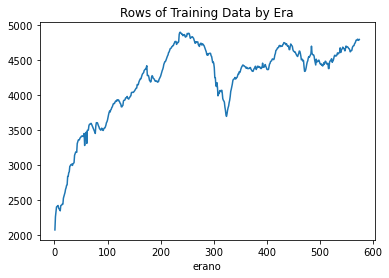

In [27]:
# check data per era
df.groupby(eras).size().plot(title="Rows of Training Data by Era");

In [30]:
# targets are discrete
df.groupby("target").size() / len(df)

target
0.00    0.050003
0.25    0.199996
0.50    0.499993
0.75    0.200015
1.00    0.049992
dtype: float64

In [52]:
# check feature correlations
feature_corrs = df.loc[df["era"]=="0001"][features].corr()
feature_corrs.stack()

feature_dichasial_hammier_spawner  feature_dichasial_hammier_spawner             1.000000
                                   feature_rheumy_epistemic_prancer              0.001690
                                   feature_pert_performative_hormuz              0.141253
                                   feature_hillier_unpitied_theobromine          0.170891
                                   feature_perigean_bewitching_thruster         -0.151098
                                                                                   ...   
feature_coactive_prefatorial_lucy  feature_centroclinal_incentive_lancelet      -0.005310
                                   feature_unemotional_quietistic_chirper        0.327181
                                   feature_behaviorist_microbiological_farina    0.324891
                                   feature_lofty_acceptable_challenge            0.044171
                                   feature_coactive_prefatorial_lucy             1.000000
Length: 11

In [53]:
# some are very correlated or uncorrelated
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

feature_calycled_living_birmingham            feature_dentilingual_removed_osmometer             -0.947381
feature_criticisable_authentical_deprecation  feature_invalid_extortionary_titillation           -0.927235
feature_hierologic_assault_candida            feature_multicostate_undescended_monoacid          -0.926623
feature_apogamic_obeisant_pondicherry         feature_splitting_sexagesimal_teutonisation        -0.923430
feature_earthlier_parian_pistachio            feature_grandmotherly_circumnavigable_homonymity   -0.913526
                                                                                                    ...   
feature_escutcheoned_timocratic_kotwal        feature_horizontal_snug_description                 1.000000
                                              feature_neptunian_supersensitive_stapler            1.000000
                                              feature_interoceptive_fifteenth_trey                1.000000
                                     